In [ ]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from nilearn import image
from os.path import basename

In [288]:
class simulation:
    def __init__(self, align=15, **kwargs):
        self.align = align
        self.kwargs = kwargs
        
    def write_time(self):
        base = {}
        combine = []
        
        for key, value in self.kwargs.items():
            base[key] = '{0}*{1}:{2}'.format((value[0] + self.align)*1.25, 1, value[2])
            with open('{0}.txt'.format(key), 'w') as f:
                f.write(base[key])
                combine.append('{0}*{1}:{2}'.format((value[0] + self.align)*1.25, value[1], value[2]))
        with open('combine.txt', 'w') as f:
            f.write('\t'.join(combine))
    
    def run_afni(self):
        self.write_time()
        os.system('./01-simulation.sh')
        
    def design_matrix(self):
        self.run_afni()
        path = './results/Simul_Main_block_deconv.x1D'
        raw = np.loadtxt(path)
        rawCols = open(path, 'r').readlines()[3].split('"')[1].split(';')
        rawCols = [i.strip() for i in rawCols]
        useCols = [i for i in rawCols if "Run" not in i if "Motion" not in i]
        df = pd.DataFrame(raw, columns=rawCols)
        df = df[useCols]
        df['TR'] = np.arange(0-self.align, df.shape[0]-self.align, 1)
        return df
    
    def plot_regressors(self, df=None):
        if df is None:
            df = self.design_matrix()
            
        fig, axes = plt.subplots(5, 1, figsize=(10, 10))
        axes = axes.flatten()

        for idx, col in enumerate(useCols):
            axes[idx].plot(df['TR'], df[col], label=col)
            if 'Base' in col:
                axes[idx].set_title('start:{0}, duration:{2}, amplitude:{1}'.format(*self.kwargs[col.lower()[:5]]))
            else:
                axes[idx].set_title('Combination of 3 basis regressors')

        for col in useCols:
            axes[idx+1].plot(df['TR'], df[col], label=col)
            axes[idx+1].set_title("All in one")

        for i in range(idx+2):
            axes[i].legend()
            axes[i].vlines(x=0, ymin=0, ymax=axes[i].get_ylim()[1], ls='--', color='black')
            axes[i].hlines(y=0, xmin=df['TR'].min(), xmax=df['TR'].max(), ls='-.', color='black', alpha=0.5)
            axes[i].set_xticks([i for i in df['TR'].values if i%2 == 0])

        _ = fig.tight_layout()
        return fig, axes

In [305]:
s = simulation(base1=[-8, 1, 1], base2=[-2, 2, 2], base3=[0, 0.1, 1])

++ '-stim_times_AM1 1 /home/songtao/ABA/local/scripts/test/base1.txt' has 2 auxiliary values per time point
++ '-stim_times_AM1 1': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 2 found in timing file '/home/songtao/ABA/local/scripts/test/base1.txt'
++ '-stim_times_AM1 2 /home/songtao/ABA/local/scripts/test/base2.txt' has 2 auxiliary values per time point
++ '-stim_times_AM1 2': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 2 found in timing file '/home/songtao/ABA/local/scripts/test/base2.txt'
++ '-stim_times_AM1 3 /home/songtao/ABA/local/scripts/test/base3.txt' has 2 auxiliary values per time point
++ '-stim_times_AM1 3': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 2 found in timing file '/home/songtao/ABA/local/scripts/test/base3.txt'
++ '-stim_times_AM1 4 /home/songtao/ABA/local/scripts/test/combine.txt' has 2 auxiliary values per time point
++ '-stim_times_AM1 4': basis function model 'dmBLOCK(1)' uses 1 parameter

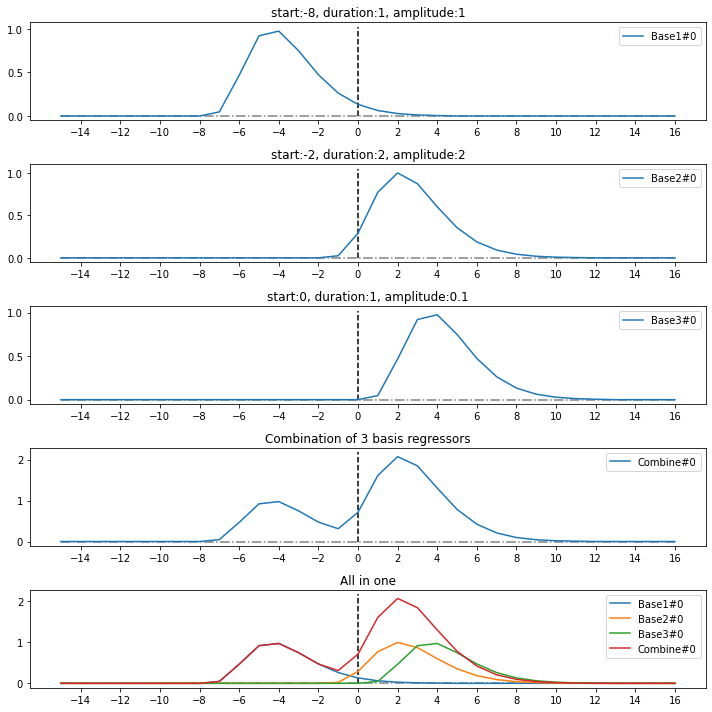

In [306]:
fig, _ = s.plot_regressors()

In [261]:
fig.savefig('./plots/example4.png', dpi=200, bbox_inches='tight')

## dataTable for 3dMVM

### Play

In [410]:
winMeanFiles = sorted(glob.glob("/home/songtao/ABA/zoopsy/results_offset/" + 
                                "first_level/voxelwise_13TR_4plays_offset_reducedRuns/assumed/Mean_withinWin/*.nii.gz"))

In [356]:
subjList = sorted(glob.glob("/home/songtao/ABA/zoopsy/results_offset/first_level/" + 
                        "voxelwise_13TR_4plays_offset_reducedRuns/assumed/ABA???"))
subjList = [basename(i) for i in subjList]

In [357]:
content = ['Subj Type Level InputFile']
for idx, subj in enumerate(subjList):
    for Type in ["Threat", "Reward"]:
        for Level in ['High', 'Low']:
            content.append("s{0} {1} {2} {3}".format(idx+1, Type, Level, 
                                                     [i for i in winMeanFiles if 
                                                      "{0}_PLAY_{1}{2}".format(subj, Level.lower(), Type[0]) in i][0]))

In [358]:
with open('/home/songtao/ABA/zoopsy/results_offset/first_level/' +
          'voxelwise_13TR_4plays_offset_reducedRuns/assumed/Mean_withinWin/subjTable.txt', 'w') as f:
    f.write("{0}\n".format(content[0]))
    for i in content[1:-1]:
        f.write("{0} \\\n".format(i))
    f.write(content[-1])

### Delivery: Received Only

In [408]:
feedRecFiles = sorted(glob.glob("/home/songtao/ABA/zoopsy/results_offset/first_level/" + 
                                "voxelwise_13TR_4plays_offset_reducedRuns/assumed/ABA???/ABA???_FEED_Rec*"))

In [411]:
content = ['Subj Type Level InputFile']
for idx, subj in enumerate(subjList):
    for Type in ["Threat", "Reward"]:
        for Level in ['High', 'Low']:
            content.append("s{0} {1} {2} {3}".format(idx+1, Type, Level, 
                                                     [i for i in feedRecFiles if 
                                                      "{0}_FEED_Rec_{1}{2}".format(subj, Level.lower(), Type[0]) in i][0]))

In [413]:
with open('/home/songtao/ABA/zoopsy/results_offset/first_level/' +
          'voxelwise_13TR_4plays_offset_reducedRuns/assumed/Group/ANOVA/FEED_RecOnly/subjTable.txt', 'w') as f:
    f.write("{0}\n".format(content[0]))
    for i in content[1:-1]:
        f.write("{0} \\\n".format(i))
    f.write(content[-1])

In [359]:
import scipy, stat

In [368]:
1 - scipy.stats.f.cdf(11.28, 1, 10)

0.007259768782231335

In [403]:
acf = [np.loadtxt(i, skiprows=1) for i in sorted(glob.glob("/home/songtao/ABA/zoopsy/results_offset/first_level/"+ 
                                                           "voxelwise_13TR_4plays_offset_reducedRuns/assumed/ACF/*.1D"))]
acf = np.array(acf)[:, :-1]

In [406]:
np.mean(acf, axis=0)

array([0.71098664, 2.55509455, 8.53983182])